# Data Analysis

This notebook performs the following steps:
1. Data analysis of HGG DB
2. Data analysis of PLGG in relation to HGG
3. Data analysis of both DBs

1. Data analysis of HGG DB:
The goal is to understand the main characteristics of HGG tumor.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

# Set basic plot parameters
plt.rcParams['figure.figsize'] = (10, 6)

# Load the cleaned dataset
df = pd.read_csv('../data/processed/HGG_DB_cleaned.csv')

# Display a preview to confirm loading
print("Dataset loaded successfully. First 5 rows:")
print(df.head())

Dataset loaded successfully. First 5 rows:
       sample dipgnbshgg location tumor_grade 3_yrs  acvr1  histone3    atrx  \
0  SJHGG059_A       DIPG  midline          IV    No  G328V       NaN     NaN   
1  SJHGG064_A       DIPG  midline          IV    No  G328W       NaN     NaN   
2  SJHGG071_A       DIPG  midline         NaN    No  G328E       NaN  T1610R   
3  SJHGG005_A       DIPG  midline          IV    No  G328V       NaN     NaN   
4  SJHGG106_A       DIPG  midline          IV    No  R258G  H3.1K27M     NaN   

  bcor bcorl1  ... ntrk123 egfr  pik3ca       pik3r1 braf  nf1 ccnd123cdk46  \
0  NaN    NaN  ...     NaN  NaN   E545K  T576_R577>R  NaN  NaN          NaN   
1  NaN    NaN  ...     NaN  NaN  H1047R          NaN  NaN  NaN          NaN   
2  NaN    NaN  ...     NaN  NaN   E545K          NaN  NaN  NaN          NaN   
3  NaN    NaN  ...     NaN  NaN     NaN          NaN  NaN  NaN          NaN   
4  NaN    NaN  ...     NaN  NaN  H1047R          NaN  NaN  NaN          NaN   

 

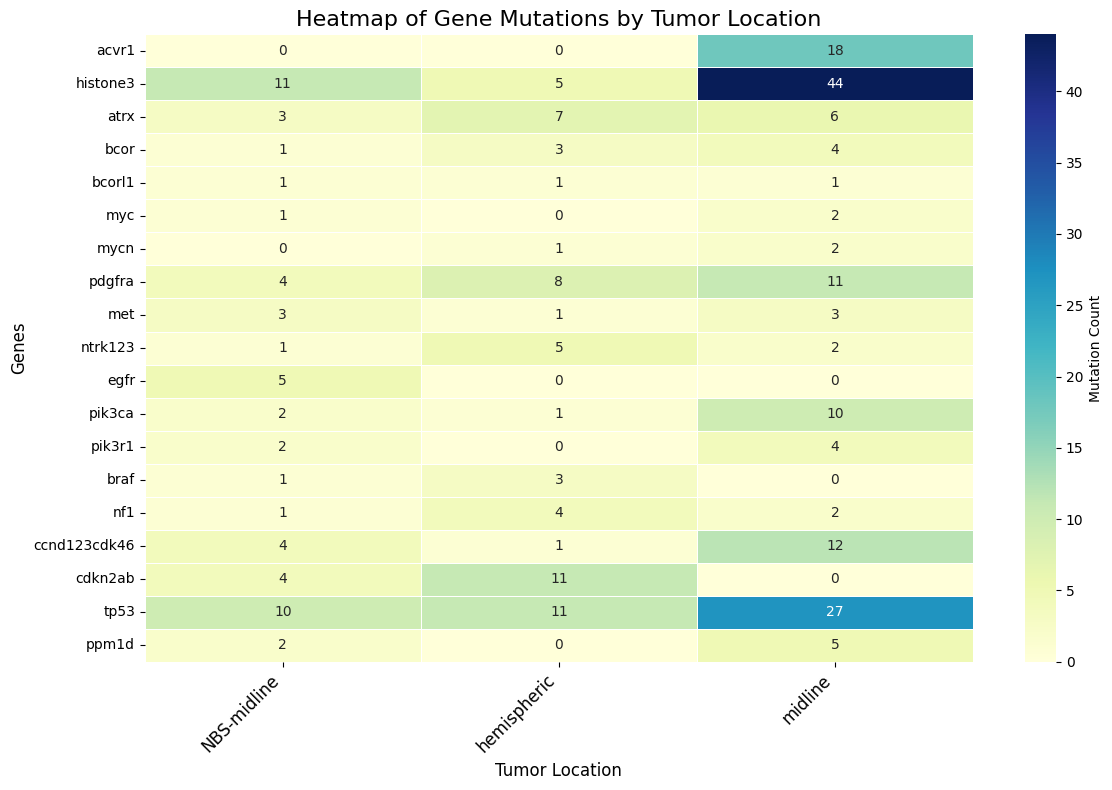

Top 5 Genes with Most Mutations by Tumor Location:


location,NBS-midline,hemispheric,midline
acvr1,0,0,18
atrx,0,7,0
ccnd123cdk46,4,0,12
cdkn2ab,0,11,0
egfr,5,0,0
histone3,11,5,44
pdgfra,4,8,11
tp53,10,11,27


C:\Users\aviga\AppData\Local\Temp\ipykernel_25220\2897731629.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


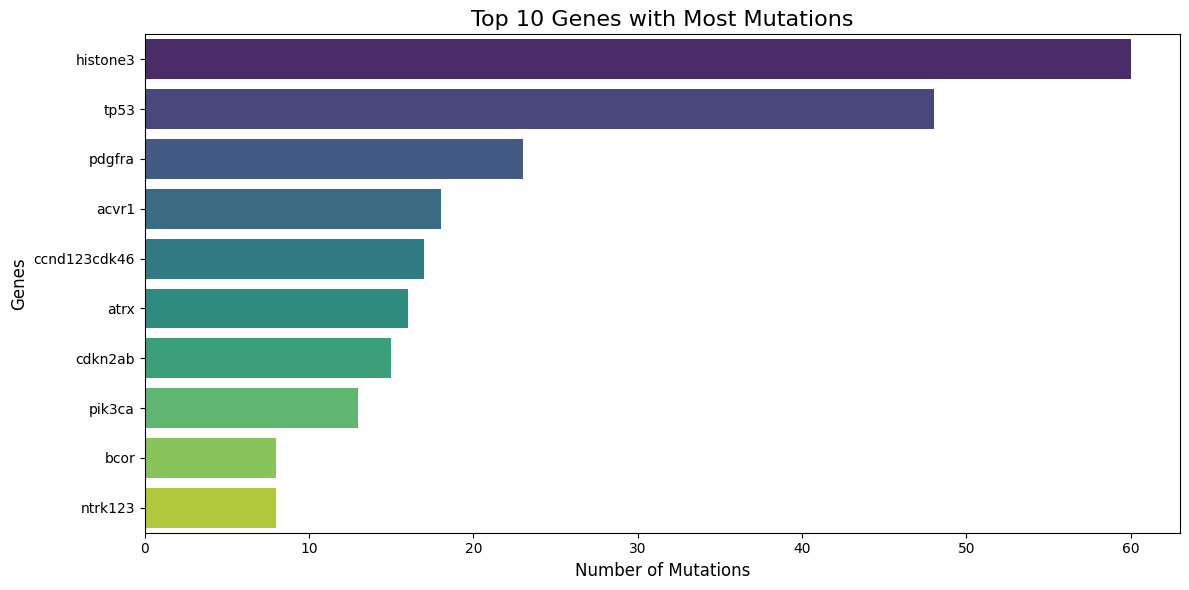

In [30]:
# Load our cleaned dataset
data = pd.read_csv('../data/processed/HGG_DB_cleaned.csv')

# Preprocess the data: Count mutations per gene for each location
mutation_columns = data.columns[5:]  # Assuming gene columns start from index 5
data["Total Mutations"] = data[mutation_columns].notna().sum(axis=1)  # Count non-NaN values for mutations

# Group by location and calculate mutation counts for each gene
mutation_by_location = data.groupby("location")[mutation_columns].apply(lambda x: x.notna().sum()).T

# Create a heatmap of mutation counts by location and gene
plt.figure(figsize=(12, 8))
sns.heatmap(
    mutation_by_location,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Mutation Count"}
)

# Customize the plot
plt.title("Heatmap of Gene Mutations by Tumor Location", fontsize=16)
plt.xlabel("Tumor Location", fontsize=12)
plt.ylabel("Genes", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Find the top 5 genes with the most mutations for each tumor location
top_genes_per_location = (
    mutation_by_location
    .apply(lambda x: x.nlargest(5))  # Select the top 5 genes for each location
    .fillna(0)  # Fill missing values with 0 for better display
    .astype(int)  # Convert to integer for readability
)

# Display the top genes
print("Top 5 Genes with Most Mutations by Tumor Location:")
display(top_genes_per_location)  

# Save the top genes table to a CSV file
top_genes_output_path = r"../data/processed/HGG_top_genes_by_location.csv"
top_genes_per_location.to_csv(top_genes_output_path)

# ----------------------------------------------------
# Create a bar plot for the top 10 genes with most mutations overall
# ----------------------------------------------------

# Step 1: Calculate total mutations for each gene across all locations
total_mutations_per_gene = mutation_by_location.sum(axis=1).sort_values(ascending=False)

# Step 2: Select the top 10 genes with the most mutations
top_10_genes = total_mutations_per_gene.head(10)

# Step 3: Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_genes.values, 
    y=top_10_genes.index, 
    palette="viridis"
)
plt.title("Top 10 Genes with Most Mutations", fontsize=16)
plt.xlabel("Number of Mutations", fontsize=12)
plt.ylabel("Genes", fontsize=12)
plt.tight_layout()


plt.show()




B. Classification of HGG genes
We wanted to know if the genes can be listed or grouped into potential functional or biological classes based on their roles in pathways or processes. so we looked at the litreture and found that the genes are classified into some classes


FunctionalClass(name=Chromatin and Transcription Regulation, genes=['histone3', 'atrx', 'bcor', 'bcorl1'])
FunctionalClass(name=RTK-RAS-PI3K Pathway, genes=['pdgfra', 'met', 'ntrk123', 'egfr', 'pik3ca', 'pik3r1', 'braf', 'myc', 'mycn'])
FunctionalClass(name=RB1 and TP53 Pathways, genes=['nf1', 'ccnd123cdk46', 'cdkn2ab', 'tp53', 'ppm1d'])
FunctionalClass(name=Other Tumor Drivers, genes=['acvr1'])


C:\Users\aviga\AppData\Local\Temp\ipykernel_25220\1330868258.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_counts, y=class_names, palette="viridis")


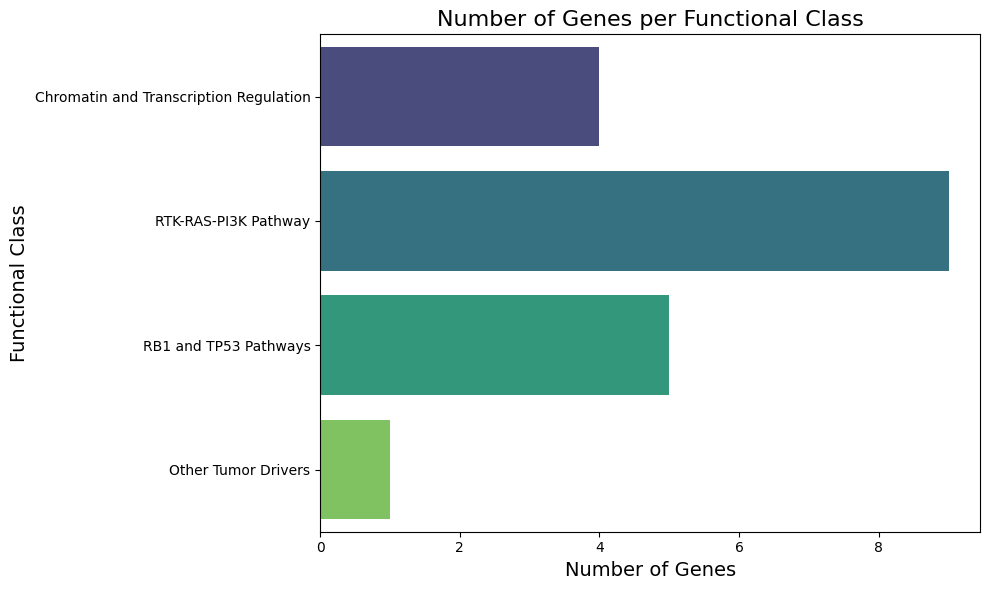

In [31]:
import seaborn as sns

# Define a class for genes
class Gene:
    def __init__(self, name, functional_class=None):
        self.name = name
        self.functional_class = functional_class

    def __repr__(self):
        return f"Gene(name={self.name}, functional_class={self.functional_class})"

# Define a class for functional classes
class FunctionalClass:
    def __init__(self, name):
        self.name = name
        self.genes = []  # List of Gene objects

    def add_gene(self, gene):
        self.genes.append(gene)

    def __repr__(self):
        return f"FunctionalClass(name={self.name}, genes={[gene.name for gene in self.genes]})"

# Step 1: Load the Classes file
classes_file_path = r"..\data\raw\Classes.organized.csv"
classes_table = pd.read_csv(classes_file_path)

# Step 2: Create FunctionalClass objects and map genes to them
functional_classes = {}

for _, row in classes_table.iterrows():
    functional_class_name = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()  # Extract all genes in this functional class

    # Create a FunctionalClass object if it doesn't exist
    if functional_class_name not in functional_classes:
        functional_classes[functional_class_name] = FunctionalClass(functional_class_name)

    # Add genes to the FunctionalClass
    for gene_name in genes:
        gene = Gene(name=gene_name, functional_class=functional_class_name)
        functional_classes[functional_class_name].add_gene(gene)

# Step 3: Display the FunctionalClass objects
for fc_name, fc_object in functional_classes.items():
    print(fc_object)


# Prepare data for plotting
class_counts = {fc_name: len(fc_object.genes) for fc_name, fc_object in functional_classes.items()}
class_names = list(class_counts.keys())
gene_counts = list(class_counts.values())

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=gene_counts, y=class_names, palette="viridis")
plt.title("Number of Genes per Functional Class", fontsize=16)
plt.xlabel("Number of Genes", fontsize=14)
plt.ylabel("Functional Class", fontsize=14)
plt.tight_layout()
plt.show()


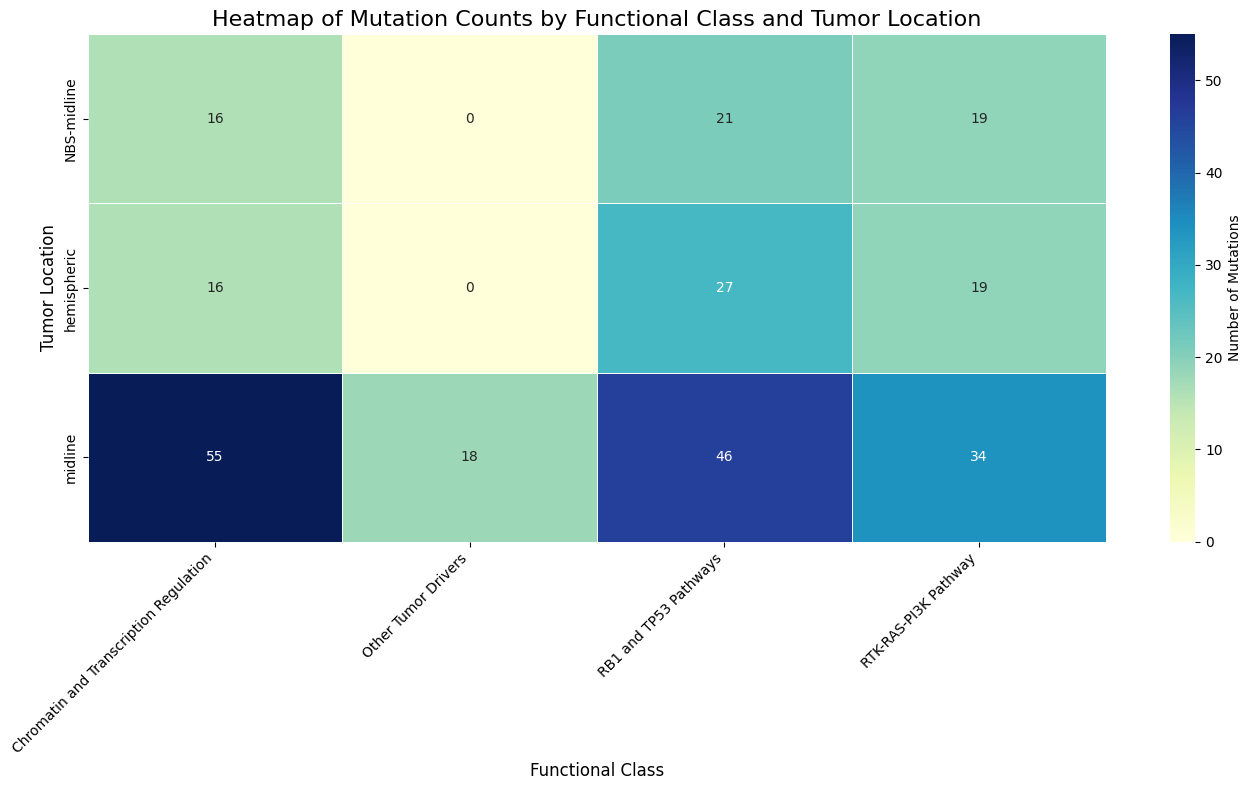

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
db_file_path = r"../data/processed/HGG_DB_cleaned.csv"
classes_file_path = r"../data/raw/Classes.organized.csv"

db_table = pd.read_csv(db_file_path)
classes_table = pd.read_csv(classes_file_path)

# Step 1: Create a mapping of genes to functional classes
gene_to_class = {}
for _, row in classes_table.iterrows():
    functional_class = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()
    for gene in genes:
        gene_to_class[gene.strip()] = functional_class

# Step 2: Identify gene columns in the HGG table
gene_columns = db_table.columns[5:]  # Assuming gene columns start at index 5

# Step 3: Melt the HGG table to long format for analysis
db_table_melted = db_table.melt(
    id_vars=["location"],  # Keep location column
    value_vars=gene_columns,  # Gene columns
    var_name="Gene",  # New column for gene names
    value_name="Mutation Value"  # New column for mutation values
)

# Step 4: Map Functional Class to each gene
db_table_melted["Gene"] = db_table_melted["Gene"].str.strip()  # Strip extra spaces
db_table_melted["Functional Class"] = db_table_melted["Gene"].map(gene_to_class)

# Step 5: Drop rows where Functional Class is not defined
db_table_melted = db_table_melted.dropna(subset=["Functional Class"])

# Step 6: Count mutations for each Functional Class and location
db_table_melted["Mutation Value"] = db_table_melted["Mutation Value"].fillna("None")  # Replace NaN with "None"
mutation_counts = (
    db_table_melted.groupby(["location", "Functional Class"])["Mutation Value"]
    .apply(lambda x: (x != "None").sum())  # Count non-"None" mutations
    .unstack(fill_value=0)  # Pivot table for heatmap
)

# Step 7: Plot the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    mutation_counts,
    annot=True,
    fmt="d",  # Show integer counts
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Mutations"}
)
plt.title("Heatmap of Mutation Counts by Functional Class and Tumor Location", fontsize=16)
plt.xlabel("Functional Class", fontsize=12)
plt.ylabel("Tumor Location", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


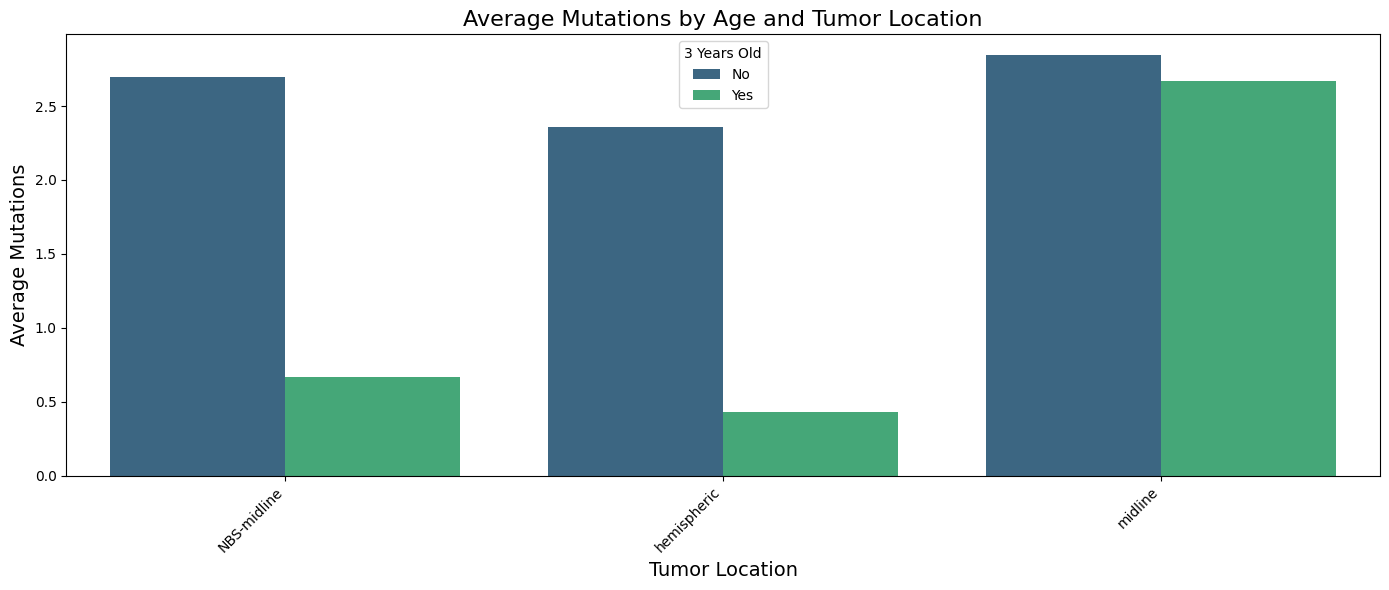

In [33]:
# Group by age (3_yrs) and calculate mutation statistics
mutation_stats = data.groupby(["3_yrs", "location"])["Total Mutations"].mean().reset_index()

# Step 3: Create a bar plot to show average mutations by age and location
plt.figure(figsize=(14, 6))
sns.barplot(
    data=mutation_stats,
    x="location",
    y="Total Mutations",
    hue="3_yrs",
    palette="viridis"
)
plt.title("Average Mutations by Age and Tumor Location", fontsize=16)
plt.xlabel("Tumor Location", fontsize=14)
plt.ylabel("Average Mutations", fontsize=14)
plt.legend(title="3 Years Old")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



<Figure size 1200x800 with 0 Axes>

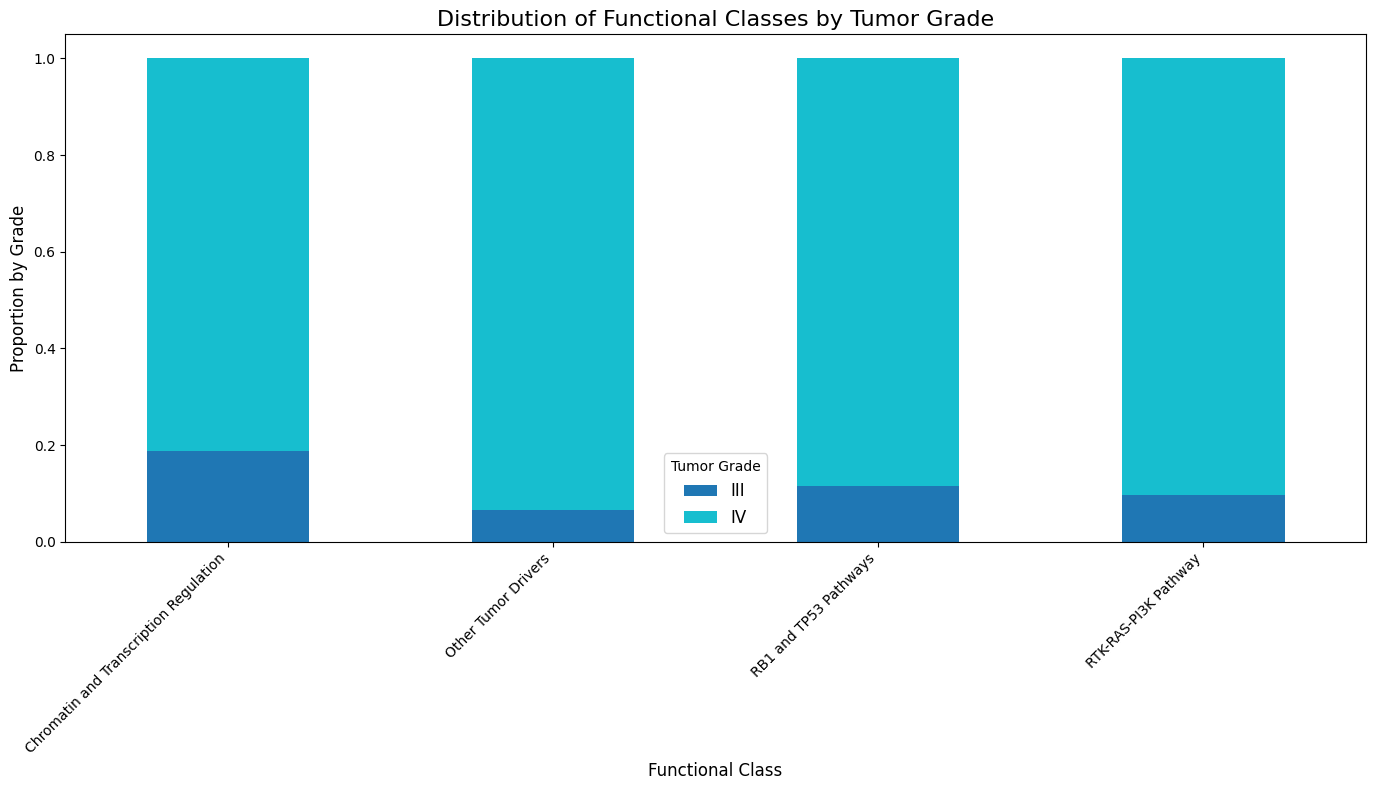

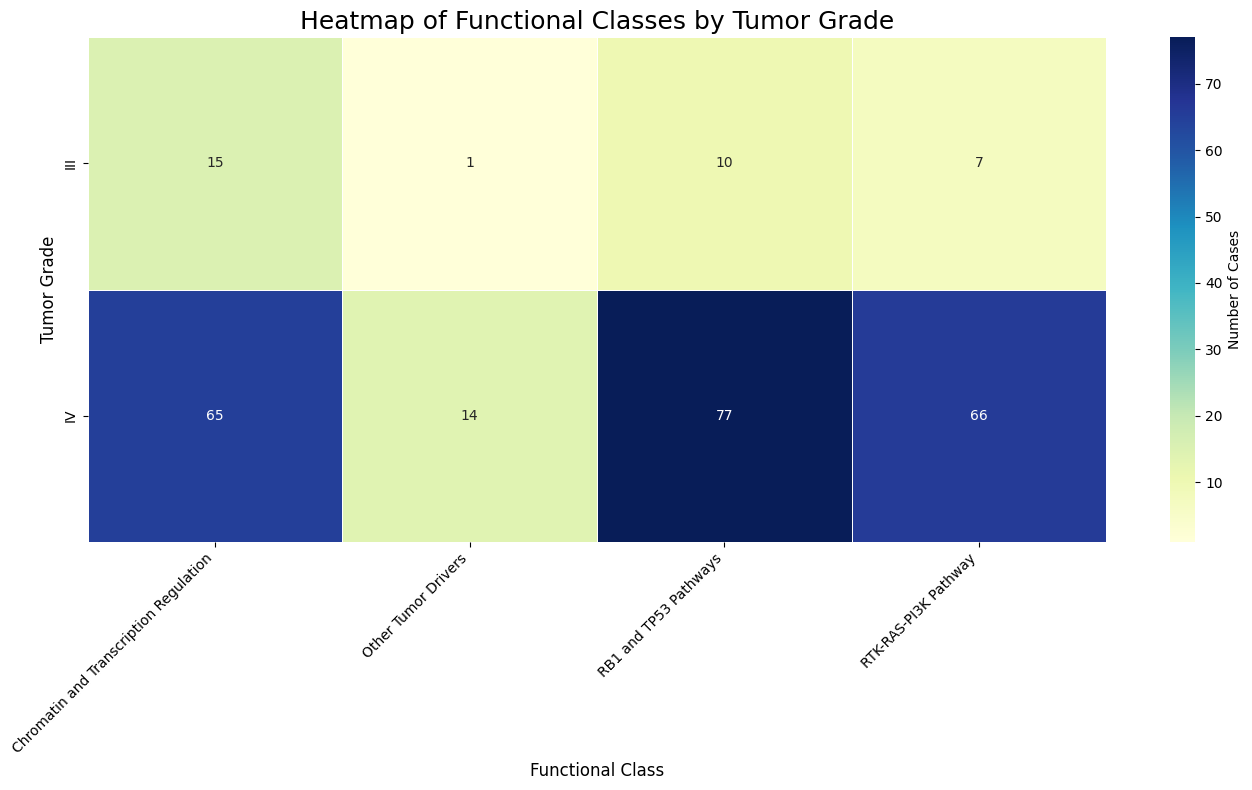

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
data_file_path = r"../data/processed/HGG_DB_cleaned.csv"
classes_file_path = r"../data/raw/Classes.organized.csv"

data = pd.read_csv(data_file_path)
classes = pd.read_csv(classes_file_path)

# Step 2: Map Functional Classes to the dataset
# Create a dictionary mapping genes to functional classes
gene_to_class = {}
for _, row in classes.iterrows():
    functional_class = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()  # Get all genes for this functional class
    for gene in genes:
        gene_to_class[gene] = functional_class

# Add Functional Class column to the data
functional_class_columns = data.columns[5:]  # Assuming gene columns start from index 5
data["Functional Class"] = data[functional_class_columns].apply(
    lambda row: [gene_to_class[gene] for gene in row.index if gene in gene_to_class and pd.notna(row[gene])],
    axis=1
)

# Explode the Functional Class column to handle multiple classes
data_exploded = data.explode("Functional Class")

# Step 3: Group data by tumor_grade and functional class
grade_class_counts = data_exploded.groupby(["tumor_grade", "Functional Class"]).size().unstack(fill_value=0)

# Step 4: Create a bar plot of Functional Classes by tumor grade
grade_class_counts_normalized = grade_class_counts.div(grade_class_counts.sum(axis=0), axis=1)

plt.figure(figsize=(12, 8))
grade_class_counts_normalized.T.plot(kind="bar", stacked=True, figsize=(14, 8), cmap="tab10")
plt.title("Distribution of Functional Classes by Tumor Grade", fontsize=16)
plt.xlabel("Functional Class", fontsize=12)
plt.ylabel("Proportion by Grade", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tumor Grade", fontsize=12)
plt.tight_layout()
plt.show()

# Step 5: Create a heatmap to show the relationship between Functional Class and Tumor Grade
plt.figure(figsize=(14, 8))
sns.heatmap(
    grade_class_counts,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Cases"}
)
plt.title("Heatmap of Functional Classes by Tumor Grade", fontsize=18)
plt.xlabel("Functional Class", fontsize=12)
plt.ylabel("Tumor Grade", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Rare Mutations

Rare Mutations (Frequency 1-2):
                  Mutation  Frequency
0             A451fs (LOH)        1.0
1                    A88fs        1.0
2    AMP;SV (DIP2C_PDGFRA)        1.0
3        Amp (CCND2, CDK4)        1.0
4          Amp;I843_M844>M        1.0
..                     ...        ...
107                  G356D        2.0
108              A529>15aa        2.0
109             Amp (CDK4)        2.0
110                  S241F        2.0
111                  R206H        2.0

[112 rows x 2 columns]


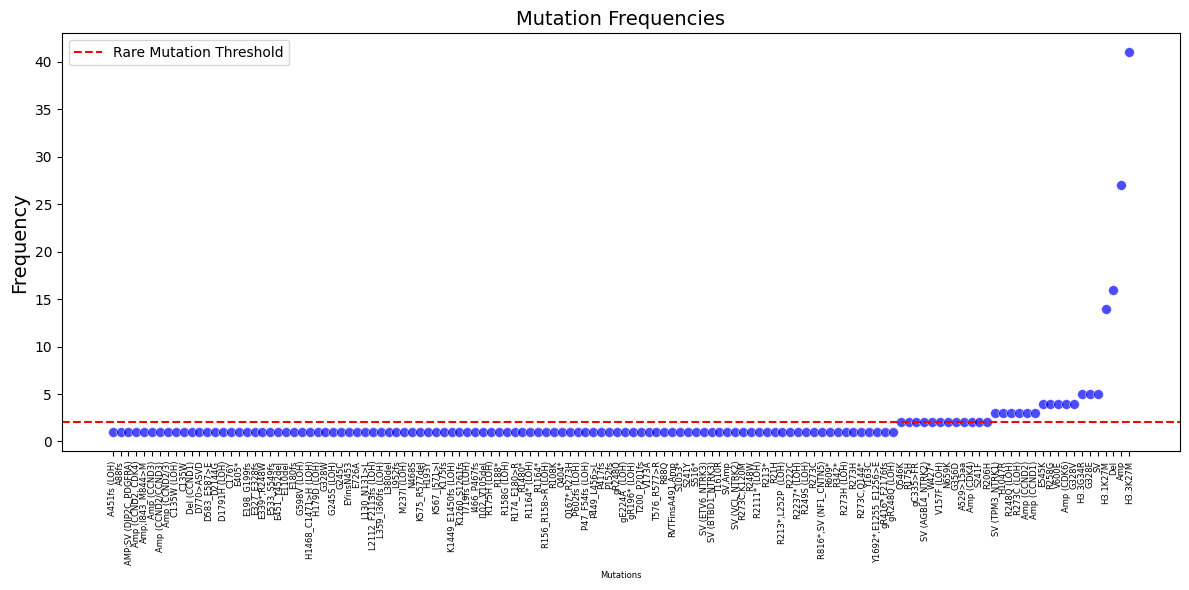

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
data_file_path = r"../data/processed/HGG_DB_cleaned.csv"
data = pd.read_csv(data_file_path)

# Step 2: Extract mutation columns
mutation_columns = data.columns[5:]  # Assuming mutation columns start from index 5

# Step 3: Count the occurrence of each mutation
mutation_counts = data[mutation_columns].apply(pd.Series.value_counts).sum(axis=1).dropna().sort_values()

# Step 4: Filter rare mutations (1-2 occurrences)
rare_mutations = mutation_counts[mutation_counts <= 2]

# Step 5: Create a table of rare mutations
rare_mutations_table = rare_mutations.reset_index()
rare_mutations_table.columns = ["Mutation", "Frequency"]

# Display the table of rare mutations
print("Rare Mutations (Frequency 1-2):")
print(rare_mutations_table)

# Step 6: Save the rare mutations table to a CSV file
output_path = "../data/processed/rare_mutations.csv"
rare_mutations_table.to_csv(output_path, index=False)

# Step 7: Create a scatter plot of mutation frequencies
plt.figure(figsize=(12, 6))
plt.scatter(
    mutation_counts.index,
    mutation_counts.values,
    alpha=0.7,
    c="blue",
    edgecolors="w",
    linewidth=0.5,
    s=50
)
plt.axhline(2, color="red", linestyle="--", label="Rare Mutation Threshold")
plt.title("Mutation Frequencies", fontsize=14)
plt.xlabel("Mutations", fontsize=6)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()


PLGG DB

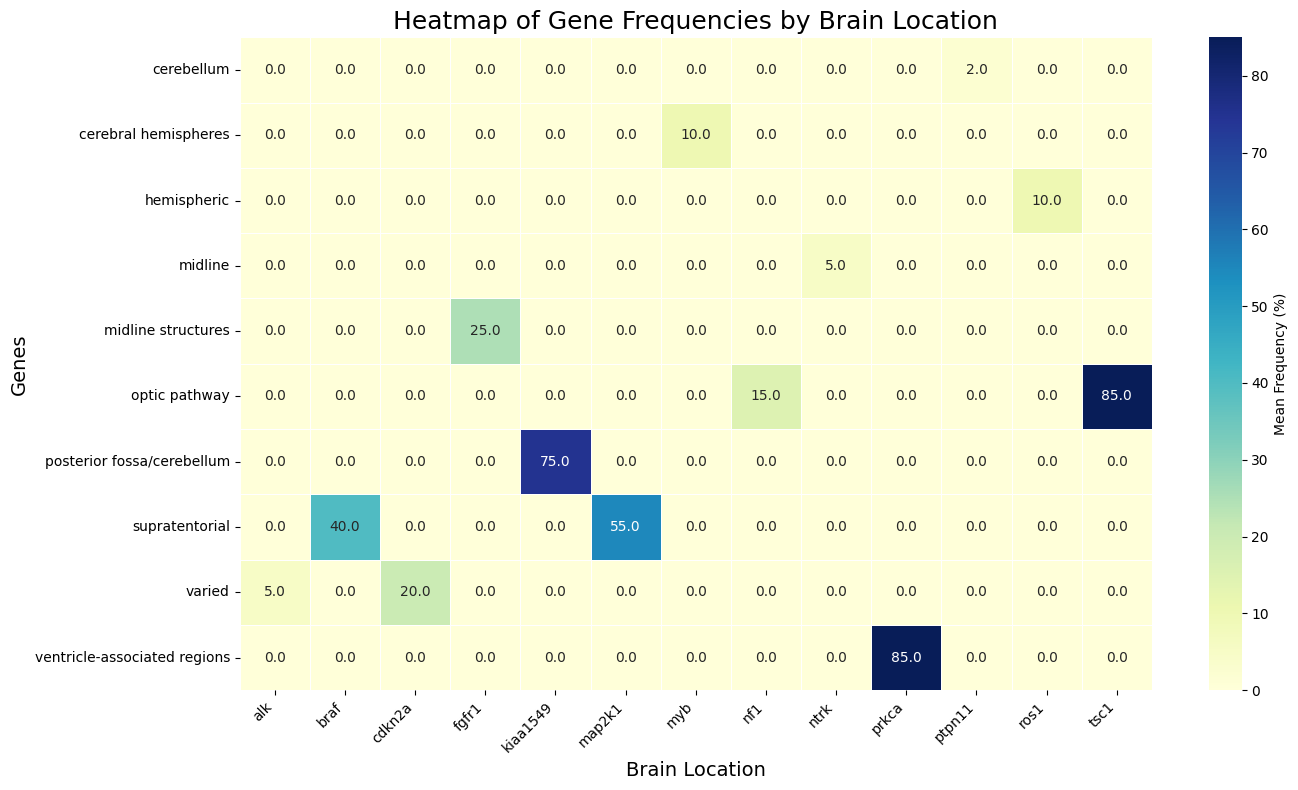

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the PLGG data
plgg_file_path = "../data/raw/PLGG_DB.csv" 
plgg_data = pd.read_csv(plgg_file_path)

# Prepare the data for the heatmap
# Group by Brain Location and Gene, and calculate the mean frequency
heatmap_data = plgg_data.groupby(["Brain Location", "Gene"])["Frequency (%)"].mean().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # Display values in the cells
    fmt=".1f",   # Format for displaying percentages
    cmap="YlGnBu",  # Colormap
    linewidths=0.5,
    cbar_kws={"label": "Mean Frequency (%)"}
)

# Customize the plot
plt.title("Heatmap of Gene Frequencies by Brain Location", fontsize=18)
plt.xlabel("Brain Location", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()







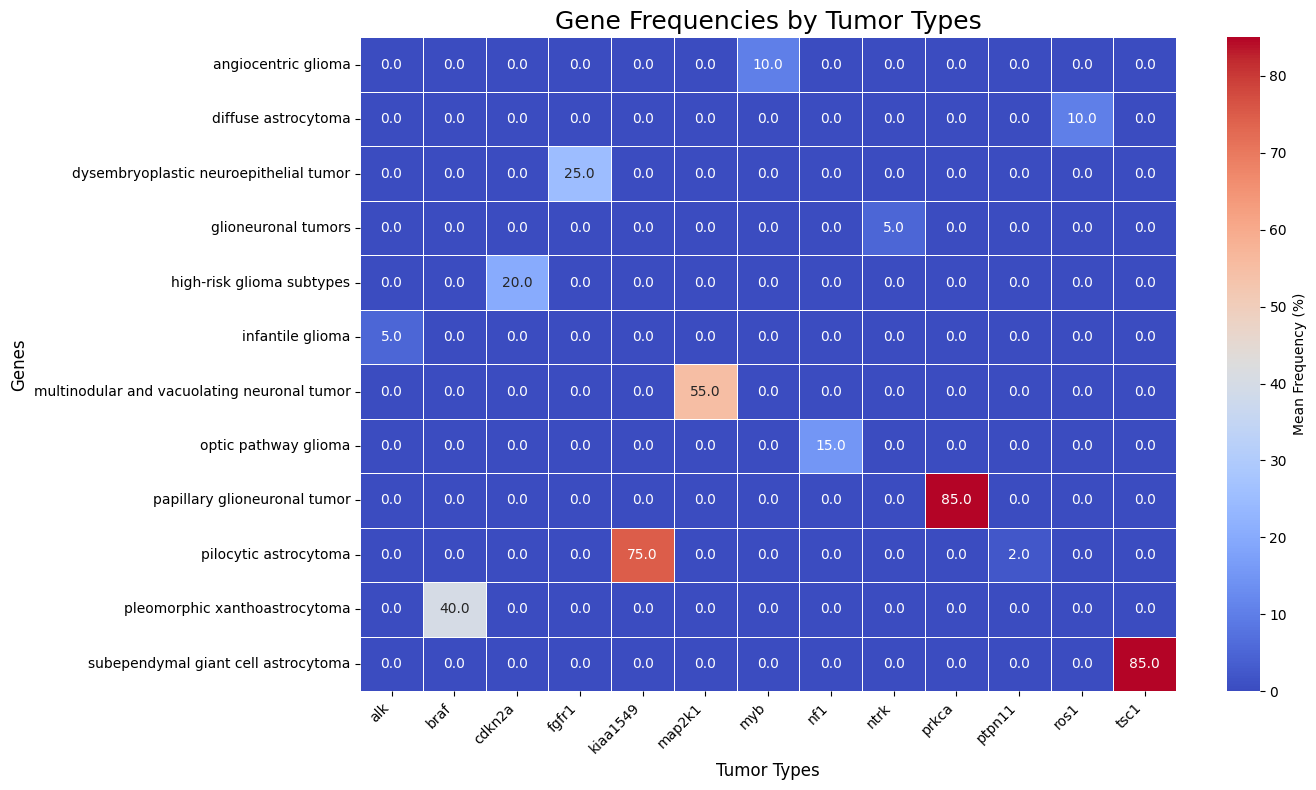

Top 5 Genes for Each Tumor Type:
Gene                                         alk  braf  cdkn2a  fgfr1  \
Tumor Types                                                             
angiocentric glioma                            0     0       0      0   
diffuse astrocytoma                            0     0       0      0   
dysembryoplastic neuroepithelial tumor         0     0       0     25   
glioneuronal tumors                            0     0       0      0   
high-risk glioma subtypes                      0     0      20      0   
infantile glioma                               5     0       0      0   
multinodular and vacuolating neuronal tumor    0     0       0      0   
optic pathway glioma                           0     0       0      0   
papillary glioneuronal tumor                   0     0       0      0   
pilocytic astrocytoma                          0     0       0      0   
pleomorphic xanthoastrocytoma                  0    40       0      0   
subependymal giant

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the PLGG data
plgg_file_path = "../data/raw/PLGG_DB.csv"
plgg_data = pd.read_csv(plgg_file_path)

# Prepare the data for analysis
# Group by Tumor Types and Gene, and calculate the mean frequency
tumor_gene_data = plgg_data.groupby(["Tumor Types", "Gene"])["Frequency (%)"].mean().unstack(fill_value=0)

# Plot a heatmap to show the relationship
plt.figure(figsize=(14, 8))
sns.heatmap(
    tumor_gene_data,
    annot=True,  # Display the frequency values
    fmt=".1f",   # Format for percentages
    cmap="coolwarm",  # Colormap
    linewidths=0.5,
    cbar_kws={"label": "Mean Frequency (%)"}
)

# Customize the plot
plt.title("Gene Frequencies by Tumor Types", fontsize=18)
plt.xlabel("Tumor Types", fontsize=12)
plt.ylabel("Genes", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Step 2: Find the top 5 genes for each tumor type
top_genes_per_tumor = (
    tumor_gene_data
    .apply(lambda x: x.nlargest(5))  # Select the top 5 genes for each tumor type
    .fillna(0)  # Replace NaN values with 0 for better display
    .astype(int)  # Convert to integer for readability
)

# Display the top genes per tumor type
print("Top 5 Genes for Each Tumor Type:")
print(top_genes_per_tumor)

# Save the top genes to a CSV file
top_genes_output_path = "../data/processed/PLGG_top_genes_by_tumor_type.csv"
top_genes_per_tumor.to_csv(top_genes_output_path)


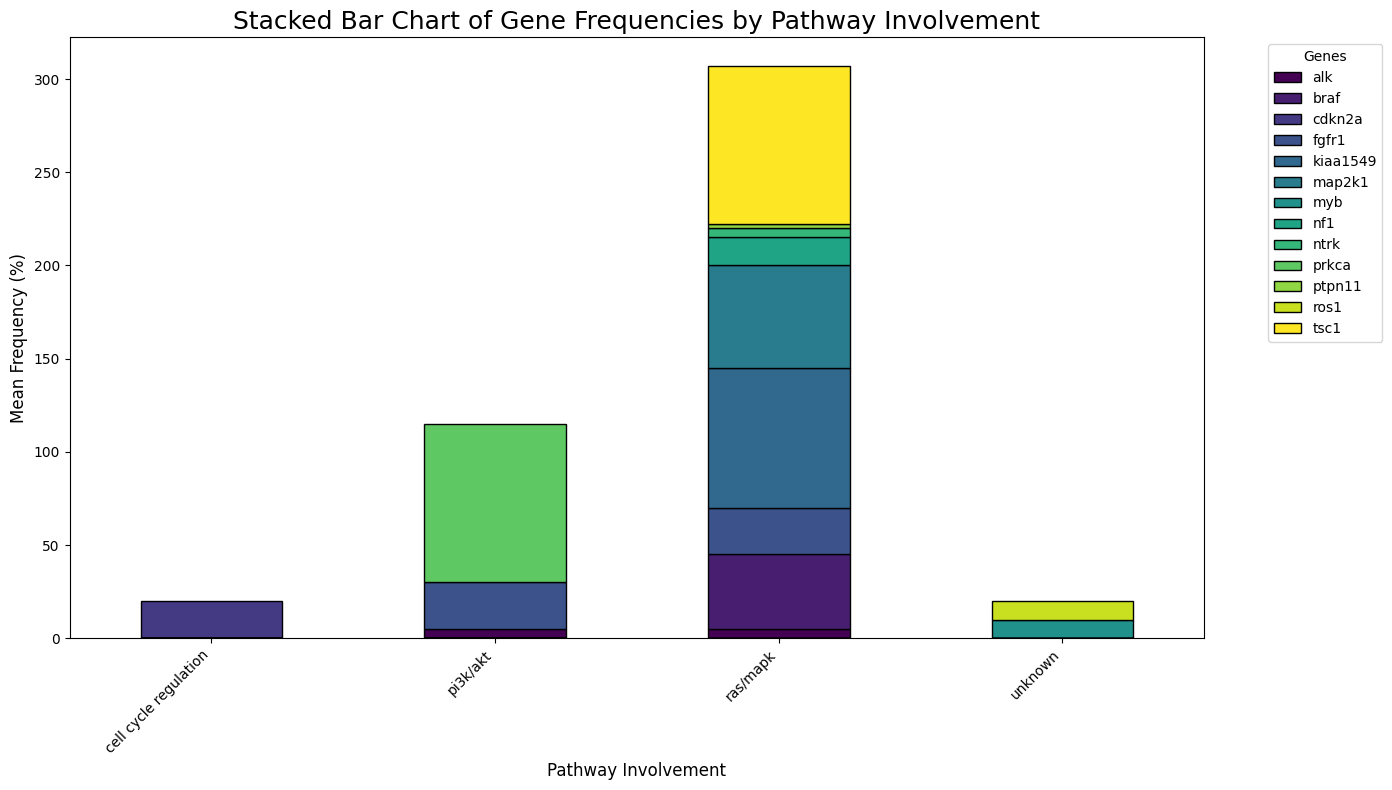

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the PLGG data
plgg_file_path = "../data/raw/PLGG_DB.csv" 
plgg_data = pd.read_csv(plgg_file_path)

# Aggregate the data by summing frequencies for each Pathway-Gene pair
pathway_gene_data = (
    plgg_data.groupby(["Pathway Involvement", "Gene"])["Frequency (%)"]
    .sum()  
    .reset_index()
)

# Pivot the data to create a structure suitable for a stacked bar chart
stacked_data = pathway_gene_data.pivot(
    index="Pathway Involvement", columns="Gene", values="Frequency (%)"
).fillna(0)

# Create a stacked bar chart
stacked_data.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 8),
    colormap="viridis",
    edgecolor="black"
)

# Customize the plot
plt.title("Stacked Bar Chart of Gene Frequencies by Pathway Involvement", fontsize=18)
plt.xlabel("Pathway Involvement", fontsize=12)
plt.ylabel("Mean Frequency (%)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()




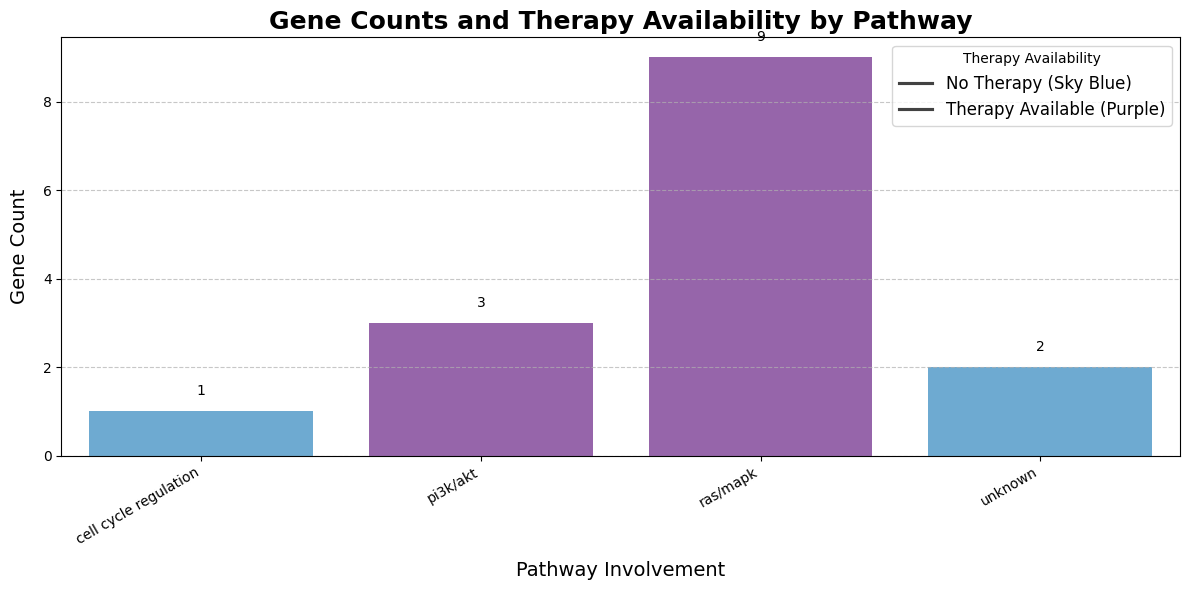

Pathways without available therapies:
     Pathway Involvement  Gene Count  Therapy Available
0  cell cycle regulation           1                  0
3                unknown           2                  0


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the PLGG data
plgg_file_path = "../data/raw/PLGG_DB.csv" 
plgg_data = pd.read_csv(plgg_file_path)

# Step 1: Count the number of genes per pathway
pathway_counts = plgg_data.groupby("Pathway Involvement")["Gene"].nunique().reset_index(name="Gene Count")

# Step 2: Simulate therapy availability for pathways
# Update based on actual therapy data if available
pathway_counts["Therapy Available"] = pathway_counts["Pathway Involvement"].apply(
    lambda x: 1 if x.lower() in ["ras/mapk", "pi3k/akt"] else 0
)

# Step 3: Create a better bar plot with custom colors
plt.figure(figsize=(12, 6))
custom_palette = {1: "#9b59b6", 0: "#5dade2"} 
sns.barplot(
    data=pathway_counts,
    x="Pathway Involvement",
    y="Gene Count",
    hue="Therapy Available",
    palette=custom_palette
)

# Customize the plot
plt.title("Gene Counts and Therapy Availability by Pathway", fontsize=18, fontweight="bold")
plt.xlabel("Pathway Involvement", fontsize=14, labelpad=10)
plt.ylabel("Gene Count", fontsize=14, labelpad=10)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)  
plt.legend(
    title="Therapy Availability",
    loc="upper right",
    labels=["No Therapy (Sky Blue)", "Therapy Available (Purple)"], 
    fontsize=12
)
plt.tight_layout()

# Add annotations to the bars
for i, row in pathway_counts.iterrows():
    x_pos = pathway_counts.index.get_loc(i)
    y_pos = row["Gene Count"]
    plt.text(
        x=x_pos, 
        y=y_pos + 0.3, 
        s=int(y_pos), 
        ha="center", 
        va="bottom", 
        fontsize=10, 
        color="black"
    )

plt.show()

# Step 4: Highlight pathways without therapy
no_therapy_pathways = pathway_counts[pathway_counts["Therapy Available"] == 0]
print("Pathways without available therapies:")
print(no_therapy_pathways)








C:\Users\aviga\AppData\Local\Temp\ipykernel_25220\3313259435.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tumor_by_age = split_table.groupby(["Age Group", "Tumor Type"]).size().reset_index(name="Count")


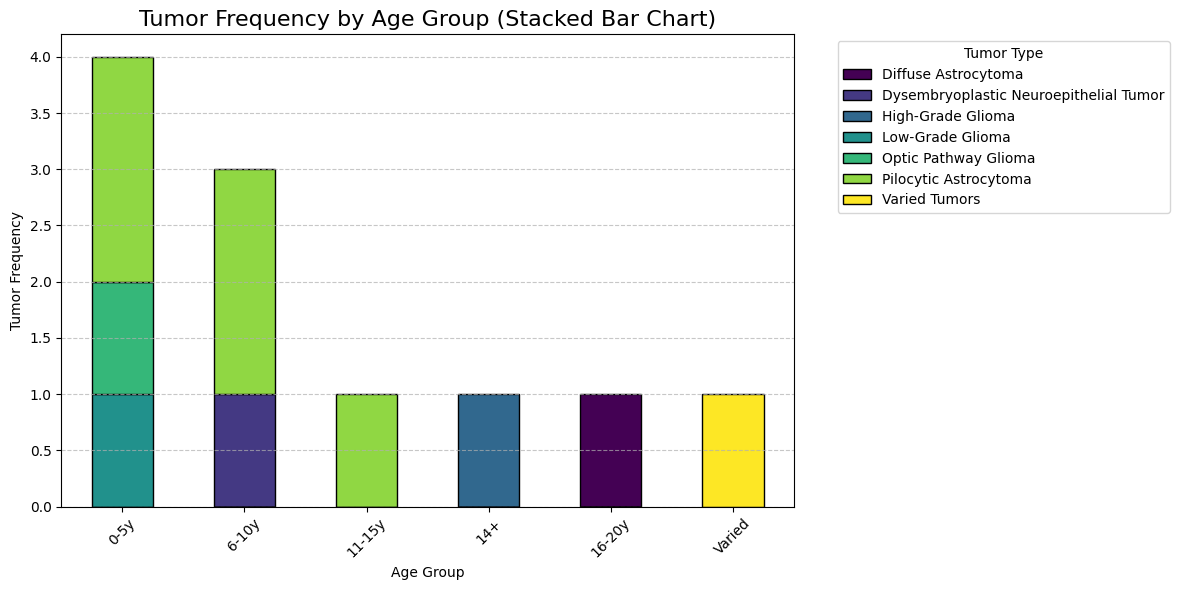

C:\Users\aviga\AppData\Local\Temp\ipykernel_25220\3313259435.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  split_table.groupby(["Age Group", "Tumor Type"])["Frequency (%)"].mean().reset_index()


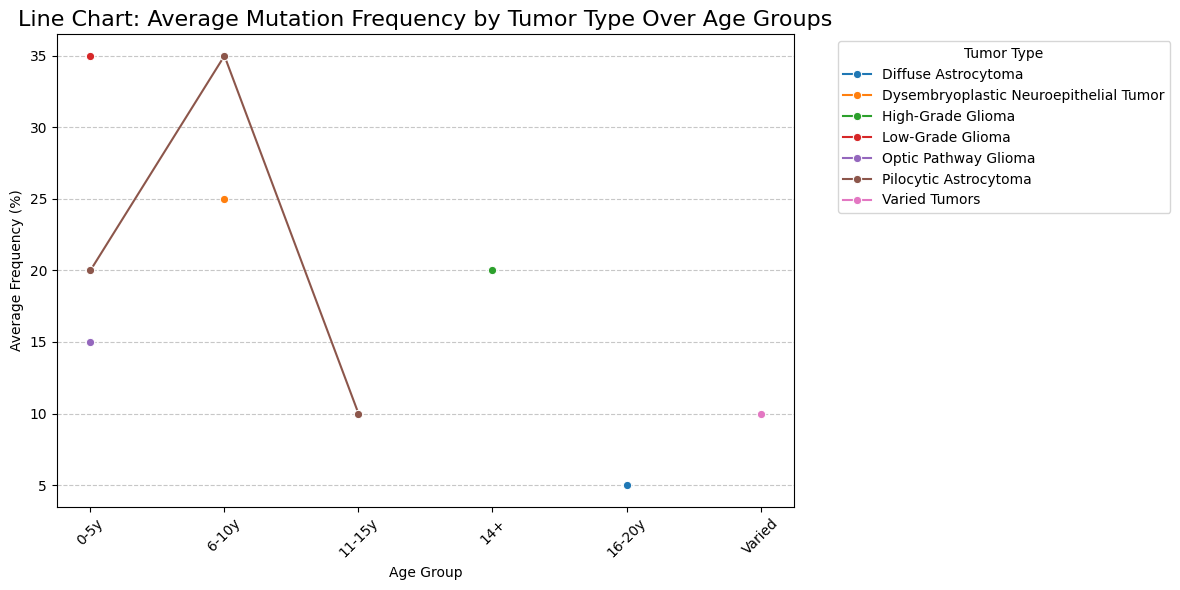

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the split table
file_path = "../data/raw/PLGG_DB_2.csv"
split_table = pd.read_csv(file_path)

# -------- Step 1: Define the chronological order for Age Group
age_order = ["0-5y", "6-10y", "11-15y", "14+", "16-20y", "Varied"]
split_table["Age Group"] = pd.Categorical(split_table["Age Group"], categories=age_order, ordered=True)

# -------- Graph 1: Stacked Bar Chart - Tumor Frequency by Age Group --------
tumor_by_age = split_table.groupby(["Age Group", "Tumor Type"]).size().reset_index(name="Count")
tumor_by_age_pivot = tumor_by_age.pivot(index="Age Group", columns="Tumor Type", values="Count").fillna(0)

tumor_by_age_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis", edgecolor="black")
plt.title("Tumor Frequency by Age Group (Stacked Bar Chart)", fontsize=16)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Tumor Frequency", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Tumor Type", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# -------- Graph 2: Line Chart - Average Mutation Frequency by Tumor Type Over Age Groups --------
avg_mutation_by_age_tumor = (
    split_table.groupby(["Age Group", "Tumor Type"])["Frequency (%)"].mean().reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_mutation_by_age_tumor,
    x="Age Group",
    y="Frequency (%)",
    hue="Tumor Type",
    marker="o",
    palette="tab10",
)
plt.title("Line Chart: Average Mutation Frequency by Tumor Type Over Age Groups", fontsize=16)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Average Frequency (%)", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Tumor Type", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



Analysis of JOINT PLGG and HGG: 

In [41]:

# Group by 'Gene' and 'Mutation Type', and keep unique rows
plgg_grouped = plgg_data.groupby(["Gene", "Mutation Type"], as_index=False).first()

# Display only the unique genes and mutations
print("PLGG: Unique Genes and Mutations:")
print(plgg_grouped[["Gene", "Mutation Type"]])

# Save to CSV
output_grouped_path = "PLGG_Unique_Genes_Mutations.csv"
plgg_grouped[["Gene", "Mutation Type"]].to_csv(output_grouped_path, index=False)
print(f"Unique genes and mutations saved to: {output_grouped_path}")


import pandas as pd

# Load the HGG dataset
hgg_file_path = "../data/processed/HGG_DB_cleaned.csv"
hgg_data = pd.read_csv(hgg_file_path)

# Display columns in the dataset
print("Columns in the dataset:")
print(hgg_data.columns)

# Automatically identify gene-related columns (from 5th column onward)
gene_columns = hgg_data.columns[5:]  # Adjust this range based on the structure of your dataset

# Melt the dataset for gene columns only
hgg_long = hgg_data.melt(
    id_vars=["sample", "location", "tumor_grade"],  # Columns to keep
    value_vars=gene_columns,  # Gene-related columns
    var_name="Gene",  # Name of the gene column
    value_name="Mutation Type"  # Name of the mutation column
)

# Convert gene and mutation names to lowercase
hgg_long["Gene"] = hgg_long["Gene"].str.lower()
hgg_long["Mutation Type"] = hgg_long["Mutation Type"].str.lower()

# Remove rows where Mutation Type is NaN
hgg_long = hgg_long[hgg_long["Mutation Type"].notna()]

# Drop duplicates to get unique Gene-Mutation combinations
hgg_unique = hgg_long[["Gene", "Mutation Type"]].drop_duplicates()

# Display the unique genes and mutations
print("Unique Genes and Mutations:")
print(hgg_unique)

# Save the processed data to a CSV file
output_path = "HGG_Unique_Genes_Mutations.csv"
hgg_unique.to_csv(output_path, index=False)
print(f"Processed data saved to: {output_path}")

PLGG: Unique Genes and Mutations:
        Gene     Mutation Type
0        alk            fusion
1       braf             v600e
2     cdkn2a          deletion
3      fgfr1   tkd duplication
4   kiaa1549            fusion
5     map2k1               snv
6        myb            fusion
7        nf1  loss of function
8       ntrk            fusion
9      prkca               snv
10    ptpn11               snv
11      ros1            fusion
12      tsc1               snv
Unique genes and mutations saved to: PLGG_Unique_Genes_Mutations.csv
Columns in the dataset:
Index(['sample', 'dipgnbshgg', 'location', 'tumor_grade', '3_yrs', 'acvr1',
       'histone3', 'atrx', 'bcor', 'bcorl1', 'myc', 'mycn', 'pdgfra', 'met',
       'ntrk123', 'egfr', 'pik3ca', 'pik3r1', 'braf', 'nf1', 'ccnd123cdk46',
       'cdkn2ab', 'tp53', 'ppm1d'],
      dtype='object')
Unique Genes and Mutations:
       Gene Mutation Type
0     acvr1         g328v
1     acvr1         g328w
2     acvr1         g328e
4     acvr1        


Number of shared genes: 3
Shared Genes: ['braf', 'nf1', 'tp53']

Number of unique genes in PLGG: 7
Number of unique genes in HGG: 17

Gene Frequency Comparison (PLGG vs HGG):
   Gene  PLGG Frequency  HGG Frequency
0  braf            30.0              4
1   nf1            15.0              7
2  tp53             5.0             48


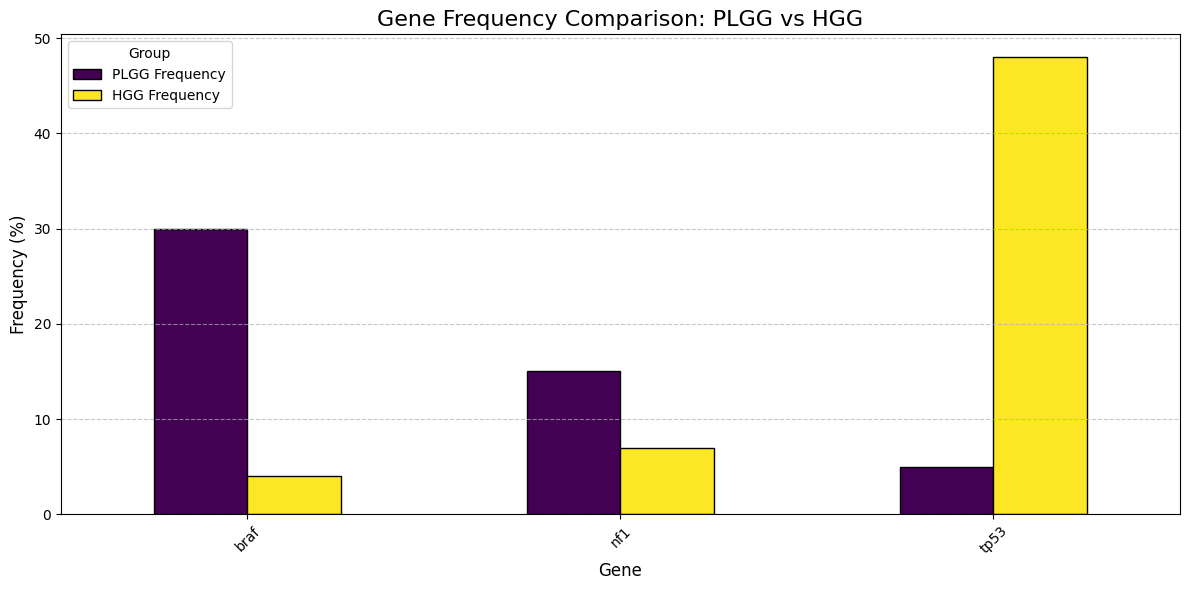


Mutation Comparison for Shared Genes:
    Gene         Mutation Type  PLGG Count  HGG Count
0   braf                 v600e         2.0        4.0
1    nf1                   del         0.0        1.0
2    nf1        gr416*,f2176fs         0.0        1.0
3    nf1          i719fs (loh)         0.0        1.0
4    nf1                l952fs         0.0        1.0
5    nf1          r2237* (loh)         0.0        1.0
6    nf1  r816*,sv (nf1_cntn5)         0.0        1.0
7    nf1                s1053*         0.0        1.0
8    nf1                   snv         1.0        0.0
9   tp53                 a88fs         0.0        1.0
10  tp53                 c135w         0.0        1.0
11  tp53           c135w (loh)         0.0        1.0
12  tp53                 c176y         0.0        1.0
13  tp53                e180fs         0.0        1.0
14  tp53           e198_g199fs         0.0        1.0
15  tp53           e339*,r248w         0.0        1.0
16  tp53                 g245c         0.0 

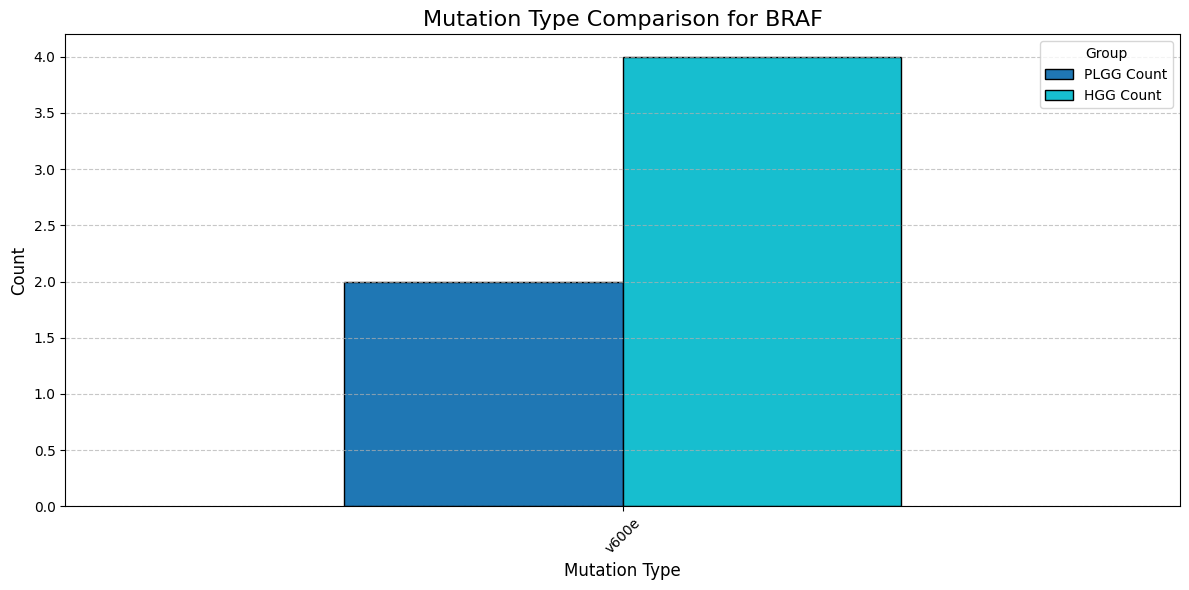

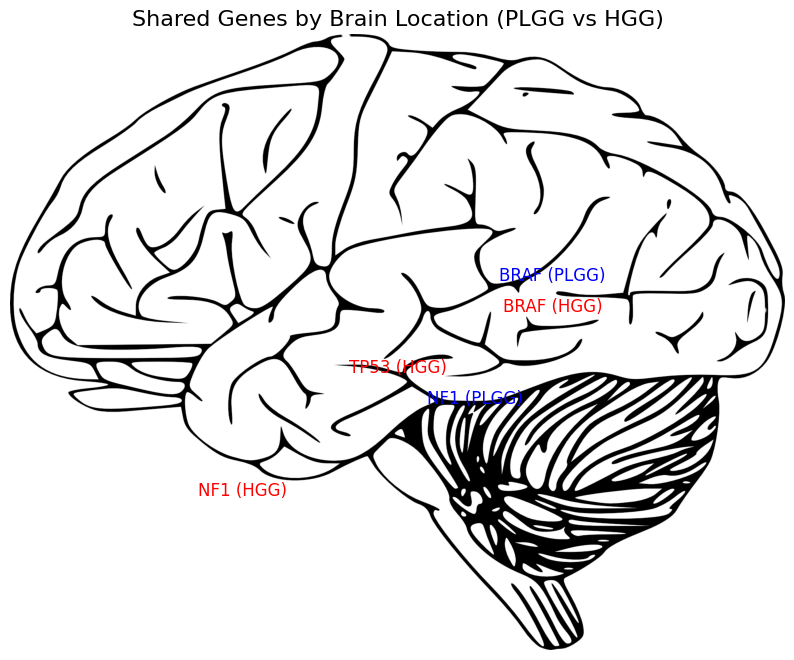

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Process PLGG dataset
plgg_file_path = "../data/raw/PLGG_DB_2.csv"
plgg_data = pd.read_csv(plgg_file_path)

# Normalize PLGG gene names
plgg_data["Gene"] = plgg_data["Gene"].str.lower().str.strip()
plgg_data["Gene"] = plgg_data["Gene"].str.replace(r"[^a-zA-Z0-9]", "", regex=True)

# Filter out non-gene entries if necessary
non_gene_entries = ["3_yrs", "sample", "location", "tumor_grade"]
plgg_data = plgg_data[~plgg_data["Gene"].isin(non_gene_entries)]

# Extract unique genes from PLGG
plgg_genes = set(plgg_data["Gene"].unique())

# Step 2: Process HGG dataset
hgg_file_path = "../data/processed/HGG_DB_cleaned.csv"
hgg_data = pd.read_csv(hgg_file_path)

# Automatically identify gene-related columns
gene_columns = [col for col in hgg_data.columns if col not in ["sample", "location", "tumor_grade", "3_yrs"]]

# Normalize HGG gene names
hgg_genes = set([col.lower().strip().replace(r"[^a-zA-Z0-9]", "") for col in gene_columns])

# Step 3: Compare genes
shared_genes = plgg_genes.intersection(hgg_genes)
unique_plgg_genes = plgg_genes.difference(hgg_genes)
unique_hgg_genes = hgg_genes.difference(plgg_genes)

# Display basic results
print(f"\nNumber of shared genes: {len(shared_genes)}")
print(f"Shared Genes: {sorted(shared_genes)}")
print(f"\nNumber of unique genes in PLGG: {len(unique_plgg_genes)}")
print(f"Number of unique genes in HGG: {len(unique_hgg_genes)}")

# Step 4: Calculate and compare frequencies
# PLGG Frequency
plgg_freq = (
    plgg_data[plgg_data["Gene"].isin(shared_genes)]
    .groupby("Gene")["Frequency (%)"]
    .mean()
    .reset_index()
    .rename(columns={"Frequency (%)": "PLGG Frequency"})
)

# HGG Frequency
hgg_long = hgg_data.melt(
    id_vars=["sample", "location", "tumor_grade"], 
    value_vars=gene_columns, 
    var_name="Gene", 
    value_name="Mutation Type"
)
hgg_long["Gene"] = hgg_long["Gene"].str.lower().str.strip()

# Calculate HGG Frequency
hgg_long["Frequency (%)"] = hgg_long["Mutation Type"].apply(lambda x: 1 if pd.notna(x) else 0)
hgg_freq = (
    hgg_long[hgg_long["Gene"].isin(shared_genes)]
    .groupby("Gene")["Frequency (%)"]
    .sum()  # Sum occurrences for each gene
    .reset_index()
    .rename(columns={"Frequency (%)": "HGG Frequency"})
)

# Merge PLGG and HGG frequencies
freq_comparison = pd.merge(plgg_freq, hgg_freq, on="Gene", how="inner")

# Display frequency comparison
print("\nGene Frequency Comparison (PLGG vs HGG):")
print(freq_comparison)

# Step 5: Plot frequency comparison
freq_comparison.plot(x="Gene", kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black")
plt.title("Gene Frequency Comparison: PLGG vs HGG", fontsize=16)
plt.xlabel("Gene", fontsize=12)
plt.ylabel("Frequency (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Group", fontsize=10)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Step 6: Compare Mutation Types for Shared Genes
# Filter PLGG and HGG for shared genes
plgg_shared_mutations = plgg_data[plgg_data["Gene"].isin(shared_genes)][["Gene", "Mutation Type"]]
hgg_shared_mutations = hgg_long[hgg_long["Gene"].isin(shared_genes)][["Gene", "Mutation Type"]]

# Normalize mutation types for comparison
plgg_shared_mutations["Mutation Type"] = plgg_shared_mutations["Mutation Type"].str.lower().str.strip()
hgg_shared_mutations["Mutation Type"] = hgg_shared_mutations["Mutation Type"].str.lower().str.strip()

# Group and count unique mutation types for each gene
plgg_mutation_counts = plgg_shared_mutations.groupby(["Gene", "Mutation Type"]).size().reset_index(name="PLGG Count")
hgg_mutation_counts = hgg_shared_mutations.groupby(["Gene", "Mutation Type"]).size().reset_index(name="HGG Count")

# Merge mutation counts to compare between PLGG and HGG
mutation_comparison = pd.merge(
    plgg_mutation_counts,
    hgg_mutation_counts,
    on=["Gene", "Mutation Type"],
    how="outer",
    suffixes=(" (PLGG)", " (HGG)")
).fillna(0)  # Replace NaN with 0 for easier comparison

# Display mutation comparison table
print("\nMutation Comparison for Shared Genes:")
print(mutation_comparison)

# Step 7: Plot Mutation Type Comparison for a Specific Gene (e.g., 'braf')
gene_to_plot = "braf"  # Specify the gene to visualize

gene_mutations = mutation_comparison[mutation_comparison["Gene"] == gene_to_plot]

if not gene_mutations.empty:
    gene_mutations.set_index("Mutation Type")[["PLGG Count", "HGG Count"]].plot(
        kind="bar", figsize=(12, 6), colormap="tab10", edgecolor="black"
    )
    plt.title(f"Mutation Type Comparison for {gene_to_plot.upper()}", fontsize=16)
    plt.xlabel("Mutation Type", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title="Group", fontsize=10)
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"No mutation data available for {gene_to_plot}.")


import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

# Load the PLGG data
plgg_file_path = "../data/raw/PLGG_DB.csv"  # Update path as needed
plgg_data = pd.read_csv(plgg_file_path)

# Filter shared genes with their brain locations
shared_genes = ["braf", "tp53", "nf1"]  # Define shared genes
plgg_data["Gene"] = plgg_data["Gene"].str.lower().str.strip()
plgg_filtered = plgg_data[plgg_data["Gene"].isin(shared_genes)]

# Define gene to brain location mapping from PLGG data
plgg_mapping = plgg_filtered.set_index("Gene")["Brain Location"].to_dict()

# Define example brain locations for HGG if needed
hgg_mapping = {
    "braf": "supratentorial",
    "tp53": "hemispheric",
    "nf1": "posterior fossa",
}

# Combine the mappings
combined_mapping = {gene: (plgg_mapping.get(gene, ""), hgg_mapping.get(gene, "")) for gene in shared_genes}

# Load the brain image
brain_image_path = "../data/raw/brain_image.png"
brain_img = plt.imread(brain_image_path)

# Plot the brain image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(brain_img, extent=[0, 10, 0, 10], aspect='auto')

# Define approximate positions for brain regions on the image
location_positions = {
    "midline": (5, 8),
    "supratentorial": (7, 6),
    "hemispheric": (5, 5),
    "posterior fossa": (3, 3),
    "optic pathway": (6, 4),
}

# Plot gene labels on the brain image
for gene, (plgg_loc, hgg_loc) in combined_mapping.items():
    if plgg_loc in location_positions:
        x, y = location_positions[plgg_loc]
        ax.text(x, y, f"{gene.upper()} (PLGG)", color="blue", fontsize=12, ha='center')
    if hgg_loc in location_positions:
        x, y = location_positions[hgg_loc]
        ax.text(x, y - 0.5, f"{gene.upper()} (HGG)", color="red", fontsize=12, ha='center')

# Finalize the plot
ax.axis('off')
plt.title("Shared Genes by Brain Location (PLGG vs HGG)", fontsize=16)
plt.show()



